In [255]:
# when importing the new dataset, compare this one with median prices to the zillow estimate 

In [256]:
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm 

from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [257]:
def stationarity_check(df):
    
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12,center=False).std()
    
    dftest = adfuller(df)
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean and std')
    plt.show(block=False)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#lags used', 'number of observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    print(dfoutput)

In [258]:
def AIC_PDQS(df):   
    ''' 
         Runs grid search to return lowest AIC result for permutataions of pdq/s values in range 0,2  
                          
         df          Dataframe to anlyse for best pdq/s permutation    
    '''
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)
    
#     Auto-Regressive (p) -> Number of autoregressive terms.
#     Integrated (d) -> Number of nonseasonal differences needed for stationarity.
#     Moving Average (q) -> Number of lagged forecast errors in the prediction equation.

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
            
    # Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    return ans_df

In [124]:
def train_sarimax(df, pdq=(0,2,2), PDQS=(0,0,0,12), summary=False):
    arima_mod = sm.tsa.statespace.SARIMAX(df, order=pdq, seasonal_order=PDQS, 
                                          enforce_stationarity=False, 
                                          enforce_invertibility=False)
    
    results = arima_mod.fit()
    
    if summary:
        print(results.summary())
    return results 

In [259]:
data = pd.read_csv('zillow_data.csv')

data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [260]:
print(f'{data.RegionName.nunique()} unique zip codes')

print('{} unique zip codes in NJ'.format(data[data.State == 'NJ'].RegionName.nunique()))

14723 unique zip codes
502 unique zip codes in NJ


In [261]:
nj = data[data.State == 'NJ']
nj.isna().sum()
# null_values = pd.DataFrame(nj.isna().sum(), columns=['sum']).sort_values(by='sum', ascending=False)
# null_values

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [262]:
melted = pd.melt(nj,id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
len(melted) #502 zip codes in NJ and 1996 to 2018 
print(melted.isna().sum())
melted.head()

RegionName    0
RegionID      0
SizeRank      0
City          0
State         0
Metro         0
CountyName    0
time          0
value         0
dtype: int64


,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,7030,60545,58,Hoboken,NJ,New York,Hudson,1996-04-01,301600.0
1,8701,61148,74,Lakewood,NJ,New York,Ocean,1996-04-01,153800.0
2,8753,61169,159,Toms River,NJ,New York,Ocean,1996-04-01,123400.0
3,7002,60518,188,Bayonne,NJ,New York,Hudson,1996-04-01,145000.0
4,7302,60639,192,Jersey City,NJ,New York,Hudson,1996-04-01,137200.0


In [263]:
df = melted[['RegionName','time','value']].rename(columns={'RegionName':'zip','value':'median_price'}).set_index('time')
df.head()

,zip,median_price
time,,
1996-04-01,7030,301600.0
1996-04-01,8701,153800.0
1996-04-01,8753,123400.0
1996-04-01,7002,145000.0
1996-04-01,7302,137200.0


## Overall NJ Analysis 

In [270]:
nj_avg = df[['median_price']].groupby('time').median_price.median().reset_index().rename(columns={'median_price':'median_price'}).set_index('time')
nj_avg = nj_avg.asfreq('MS')
nj_avg

,median_price
time,
1996-04-01,156650.0
1996-05-01,156650.0
1996-06-01,156600.0
1996-07-01,156550.0
1996-08-01,156450.0
...,...
2017-12-01,331650.0
2018-01-01,333050.0
2018-02-01,334100.0


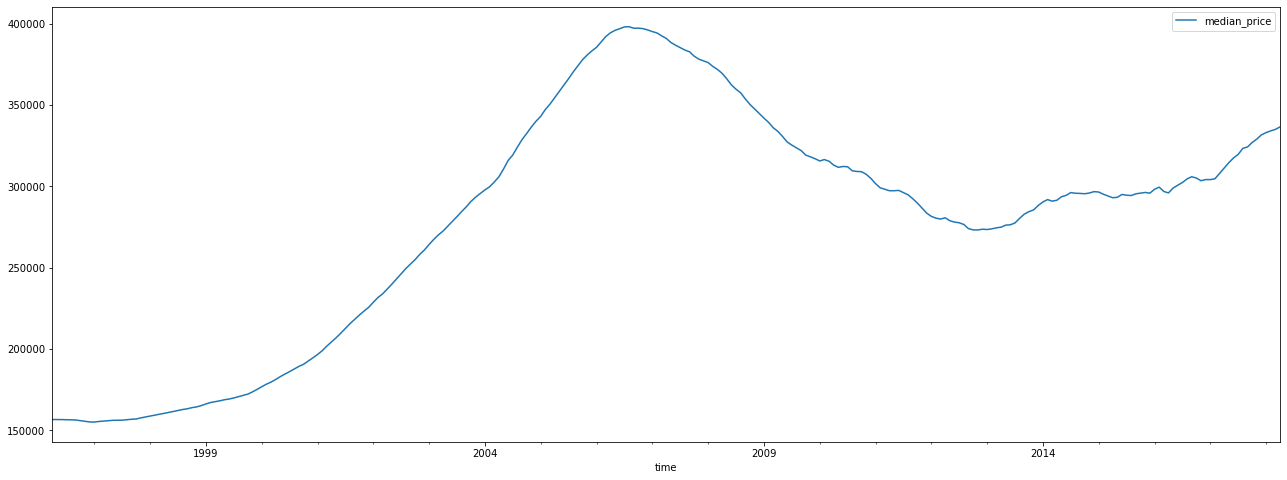

In [271]:
nj_avg.plot(figsize=(22,8))
# TODO add in minimums and lines for recession 
plt.show()

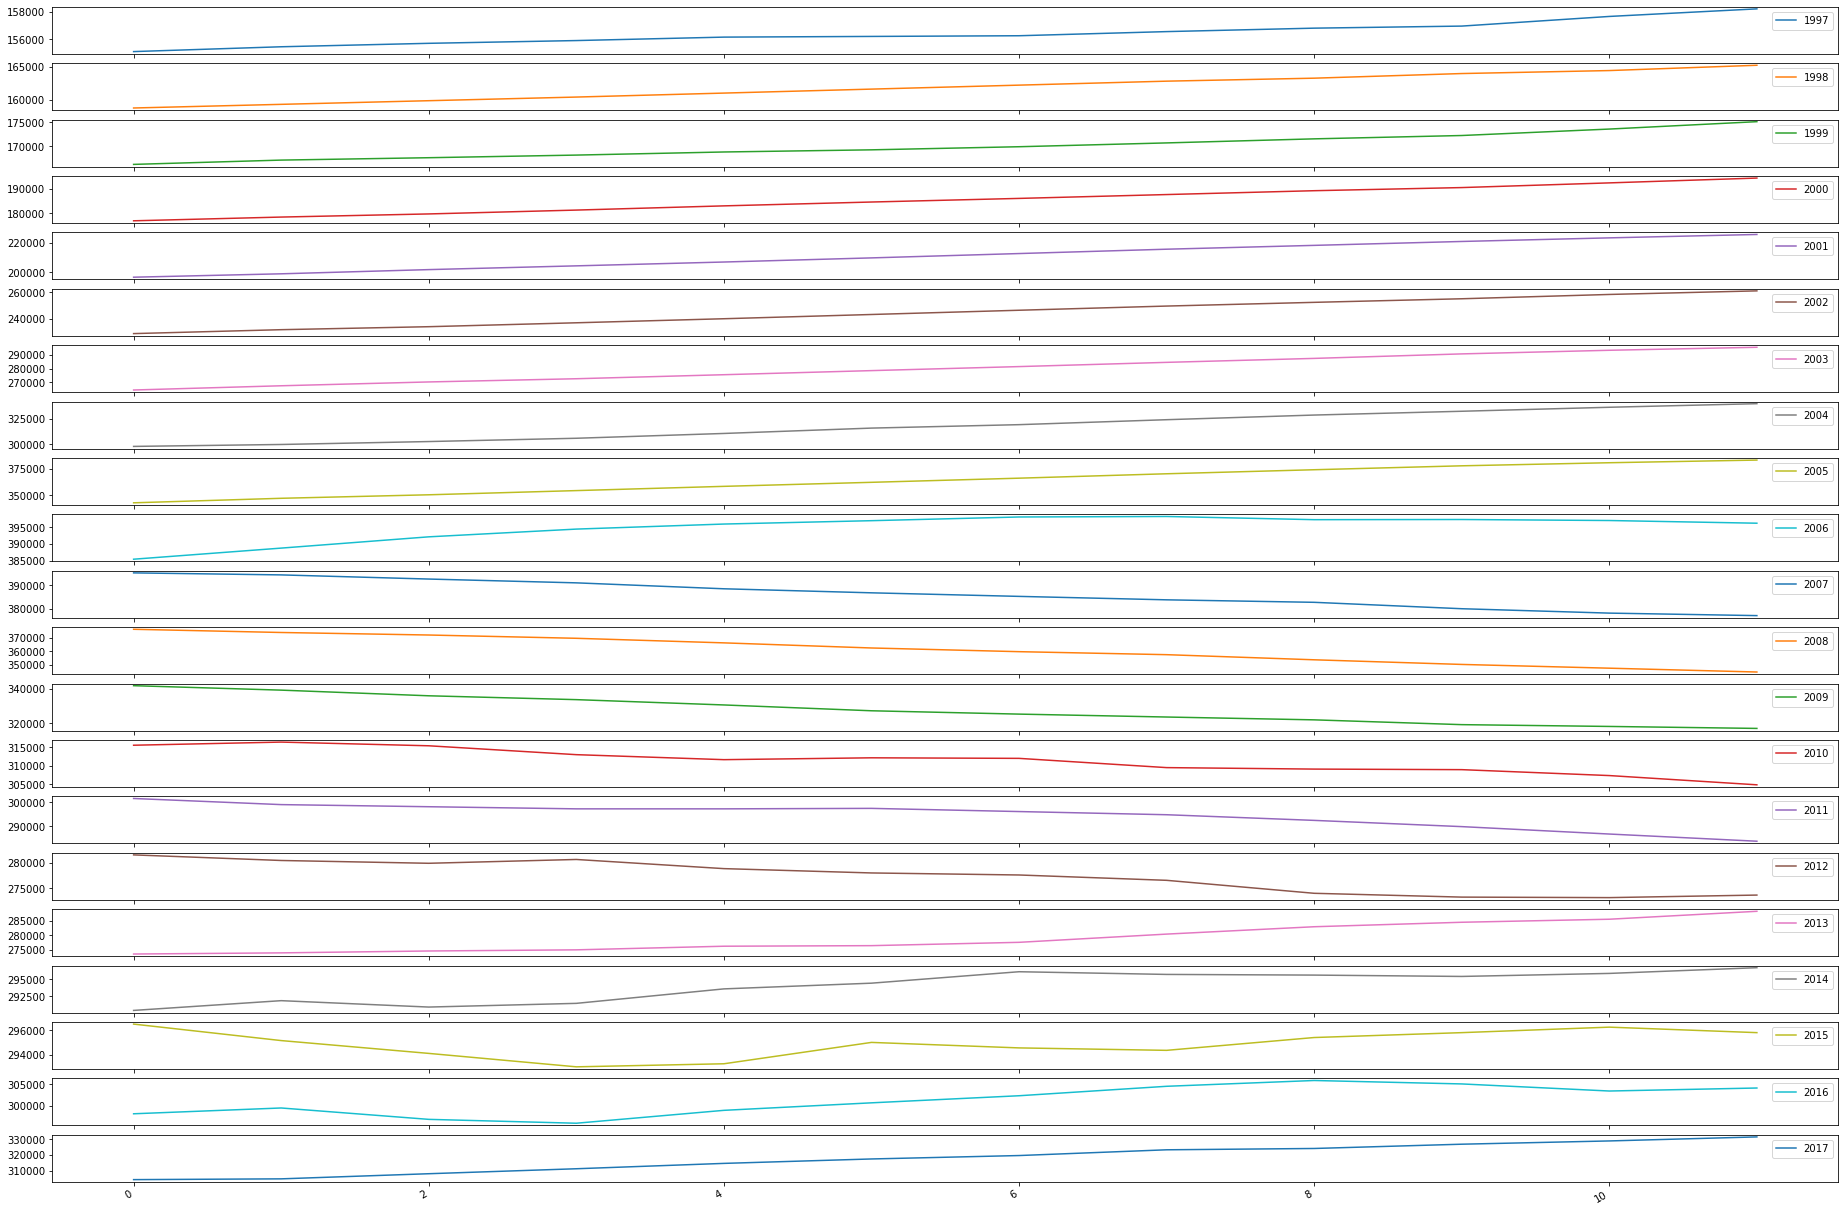

In [29]:
# not full years in 96 and 2018 
year_groups = nj_avg['1997':'2017'].groupby(pd.Grouper(freq='A'))
temp_annual = pd.DataFrame()
for yr, group in year_groups:
    temp_annual[yr.year] = group.values.ravel()
temp_annual.plot(figsize=(32,24),subplots=True, legend=True)
plt.show()

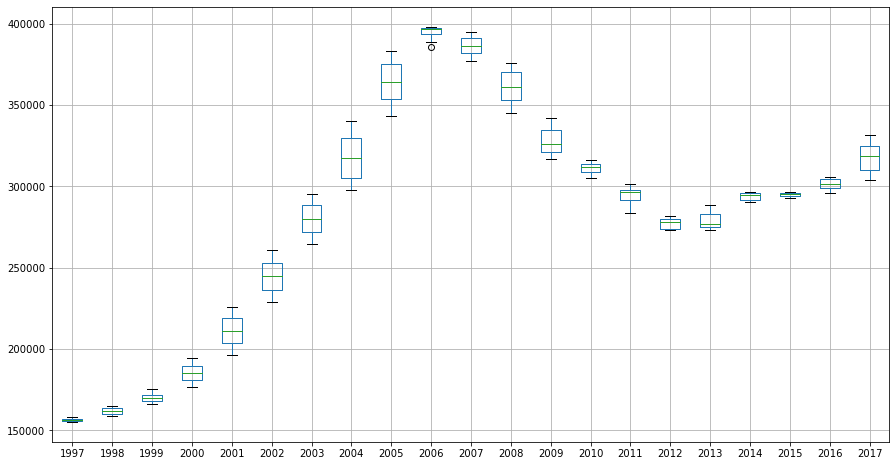

In [30]:
temp_annual.boxplot(figsize=(15,8))
plt.show()

In [ ]:
""" 
d=2 
p=1 
q=1 (slightly over differenced based on the immediate negative correlation for the acf plot)
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. 
Likewise, if it is slightly over-differenced, try adding an additional MA term.

"""

In [273]:
nj_avg_m = nj_avg.resample('MS').sum()
nj_avg_m = nj_avg_m['2012':]

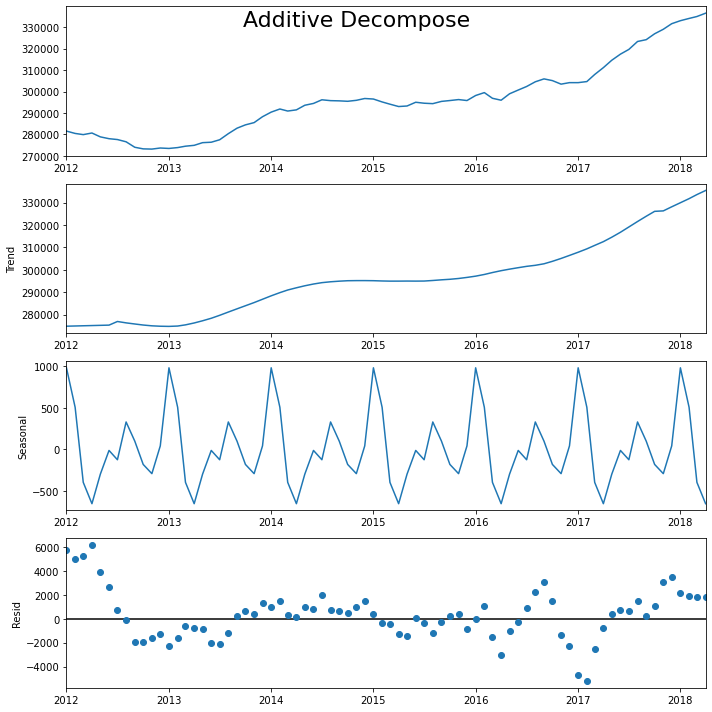

In [274]:
result_add = seasonal_decompose(nj_avg_m, model='additive', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

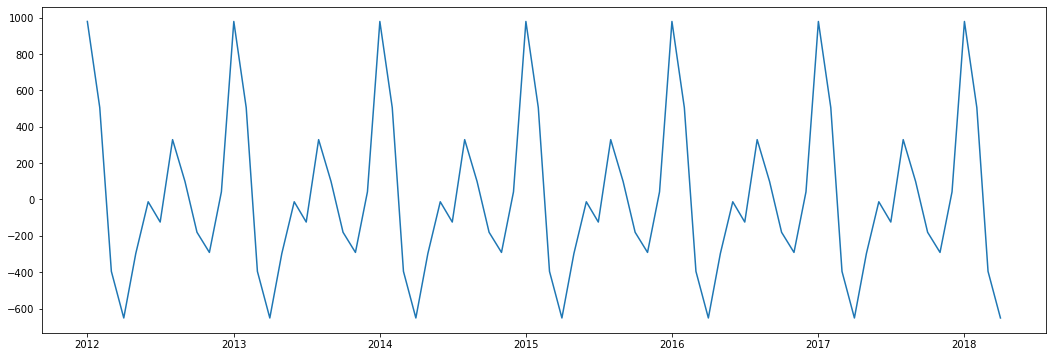

In [254]:
plt.figure(figsize=(18,6))
# TODO add dotted lines 
plt.plot(result_add.seasonal)
plt.show()

In [278]:
AIC_PDQS(train) # TODO - make this output pdq, and PDQ so it can be added to next method 

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1064.3005163876799
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =825.9029975830189
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =563.2993467665573
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =319.66325005871096
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =569.8981864908756
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =535.3633635753469
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =332.54459570624493
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =288.2305397552647
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1012.387679343088
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =790504.664971435
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =557.7803611306982
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =278.8556932287894
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =733.8741397085357
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =681.9445594403446
ARIMA (0, 0, 1) x 

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",1064.300516
1,"(0, 0, 0)","(0, 0, 1, 12)",825.902998
2,"(0, 0, 0)","(0, 1, 0, 12)",563.299347
3,"(0, 0, 0)","(0, 1, 1, 12)",319.663250
4,"(0, 0, 0)","(1, 0, 0, 12)",569.898186
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",215.426257
60,"(1, 1, 1)","(1, 0, 0, 12)",425.304026
61,"(1, 1, 1)","(1, 0, 1, 12)",1064.549285
62,"(1, 1, 1)","(1, 1, 0, 12)",226.663716


In [248]:

# train test split 
train = nj_avg_m.loc['2012':'2015-03-01']
test = nj_avg_m.loc['2015-04-01':]

results = train_sarimax(train, pdq=(0,1,1), PDQS=(1,1,1,12), summary=True)
results.plot_diagnostics(figsize=(14,10))
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                       median_price   No. Observations:                   76
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -431.556
Date:                            Sat, 05 Mar 2022   AIC                            871.111
Time:                                    16:05:36   BIC                            878.679
Sample:                                01-01-2012   HQIC                           873.982
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2672      0.081      3.310      0.001       0.109       0.425
ar.S.L12      -0.5179      0.206   

In [ ]:
# training data 

fig,ax=plt.subplots(figsize=(12,5))
train_data['2011':].plot(ax=ax, label='actual')
predict.predicted_mean.loc['2011':'2015-04-01'].plot(ax=ax, style='r--', label='one step ahead forecast')
# predict_dy.predicted_mean.loc['2014-01-01':].plot(ax=ax,style='g', label='Dynamic Forecast')
legend=ax.legend(loc='lower right')

In [ ]:
# walk-forward validation


In [249]:
# dynamic prediction 
pred = results.get_prediction(start=pd.to_datetime('2015-04-01'), end=pd.to_datetime('2018-04-01'), dynamic=True)
pred_ci = pred.conf_int()

plt.figure(figsize=(12,5))
plt.plot(train['2014-01-01':], label='training')
plt.plot(test, label='test')
plt.plot(pred.predicted_mean, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs. Actuals')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
print(f'RMSE: {np.sqrt(mean_squared_error(y_forecasted, test))}')

## Model Prototyping (Overall NJ prices) 

## Get top 25 zip codes 
* long term returns (top 200) 
* short term returns (top 100) 
* top median yearly returns (top 50) 
* lowest volatility / risk (top 25) 

In [18]:
data = pd.read_csv('zillow_data.csv')

def prep_df(data, state='NJ'):
    nj = data[data.State == 'NJ']
    melted = pd.melt(nj,id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    df = melted[['RegionName','time','value']].rename(columns={'RegionName':'zip','value':'median_price'}).set_index('time')
    return df
df = prep_df(data)

In [19]:
df.head()

,zip,median_price
time,,
1996-04-01,7030,301600.0
1996-04-01,8701,153800.0
1996-04-01,8753,123400.0
1996-04-01,7002,145000.0
1996-04-01,7302,137200.0


In [20]:
montville = df[df.zip==7058]

# Long term returns

## Total ROI

In [21]:
def get_roi(df, num):
    def roi(series):
        return series.iloc[-1] / series.iloc[0]
    zip_roi = df.groupby('zip').agg({'median_price':roi}).rename(columns={'median_price':'roi'}).reset_index().sort_values(by='roi', ascending=False)
    return zip_roi.iloc[:num,:], list(zip_roi.iloc[:num,:].zip.unique())

get_roi(df, 10)

(      zip        roi
 92   7302  10.403061
 23   7030   6.148210
 216  7756   5.418274
 191  7720   5.088816
 69   7086   4.926930
 352  8202   4.923441
 94   7306   4.896768
 95   7307   4.782152
 188  7717   4.754368
 368  8247   4.365571,
 [7302, 7030, 7756, 7720, 7086, 8202, 7306, 7307, 7717, 8247])

## Median annual ROI 

In [22]:
def get_annual_roi(df,num):
    
    def annual_roi(series):
        years = list(df.index.year.unique())
        annual_rois = []
        for index, year in enumerate(years):
            curr_index = int(index * 12) 
            if curr_index != 0:
                curr_year = series.iloc[curr_index]
                prev_year = series.iloc[curr_index - 12]
                annual_roi = curr_year / prev_year
                annual_rois.append(annual_roi)
        return np.median(annual_rois)

    zip_annual_roi = df.groupby('zip').agg({'median_price':annual_roi}).rename(columns={'median_price':'median_annual_roi'}).reset_index()
    return zip_annual_roi.iloc[:num,:], list(zip_annual_roi.iloc[:num,:].zip.unique())

get_annual_roi(df,10)[1]

[7001, 7002, 7003, 7004, 7005, 7006, 7008, 7009, 7010, 7011]

# Short Term Returns 

* 3 year investment returns 

In [23]:
def get_short_roi(df, time_horizon=3,num=10):
    
    def short_roi_calc(series):
        index = series.index[-1] - pd.Timedelta(days=(365*time_horizon))
        index = pd.Timestamp(year=index.year,month=index.month,day=1)
        return series.iloc[-1] / series[index]
   
    zip_roi = df.groupby('zip').agg({'median_price':short_roi_calc}).rename(columns={'median_price':f'{time_horizon}_year_roi'}).reset_index().sort_values(by=f'{time_horizon}_year_roi', ascending=False)

    return zip_roi.iloc[:num,:], list(zip_roi.iloc[:num,:].zip.unique())

get_short_roi(df, 3, 10)[1]

[7302, 7307, 7306, 7305, 7050, 7086, 7114, 7063, 7087, 8751]

# Risk/Volatility 

In [24]:
# lowest risk 
def get_volatility(df,num):
    
    def cv_calc(series):
        coef_variation = series.std() / series.mean()
        return coef_variation 
    
    result = df.groupby('zip').agg({'median_price':cv_calc}).reset_index().sort_values(by='median_price', ascending=True).rename(columns={'median_price':'cv'})
    return result.iloc[:num,:], list(result.iloc[:num,:].zip.unique())

get_volatility(df,10)[0]

,zip,cv
470,8833,0.195889
487,8867,0.197158
449,8801,0.197629
450,8802,0.199290
229,7830,0.201518
464,8826,0.203661
262,7931,0.203956
261,7930,0.203977
496,8886,0.204435
465,8827,0.204837


In [25]:
long_roi_zips = get_roi(df, 200)[1]
long_roi = df.loc[df['zip'].isin(long_roi_zips)]
print(long_roi['zip'].nunique())

short_roi_zips = get_short_roi(long_roi, 3, 100)[1]
short_roi = df.loc[df['zip'].isin(short_roi_zips)]
print(short_roi['zip'].nunique())

annual_roi_zips = get_annual_roi(short_roi,50)[1]
annual_roi = df.loc[df['zip'].isin(annual_roi_zips)]
print(annual_roi['zip'].nunique())

volatility_zips = get_volatility(annual_roi,25)[1]
volatility = df.loc[df['zip'].isin(volatility_zips)]
print(volatility['zip'].nunique())
print(volatility['zip'].unique())
volatility
# df = volatility(df,10)
# df

200
100
50
25
[7003 7601 7024 7052 7032 7110 7010 7424 7016 7071 7094 7070 7081 7020
 7066 7044 7057 7073 7075 7512 7033 7004 7072 7014 7088]


,zip,median_price
time,,
1996-04-01,7003,140800.0
1996-04-01,7601,157500.0
1996-04-01,7024,260200.0
1996-04-01,7052,165300.0
1996-04-01,7032,150300.0
...,...,...
2018-04-01,7033,361800.0
2018-04-01,7004,528600.0
2018-04-01,7072,404600.0


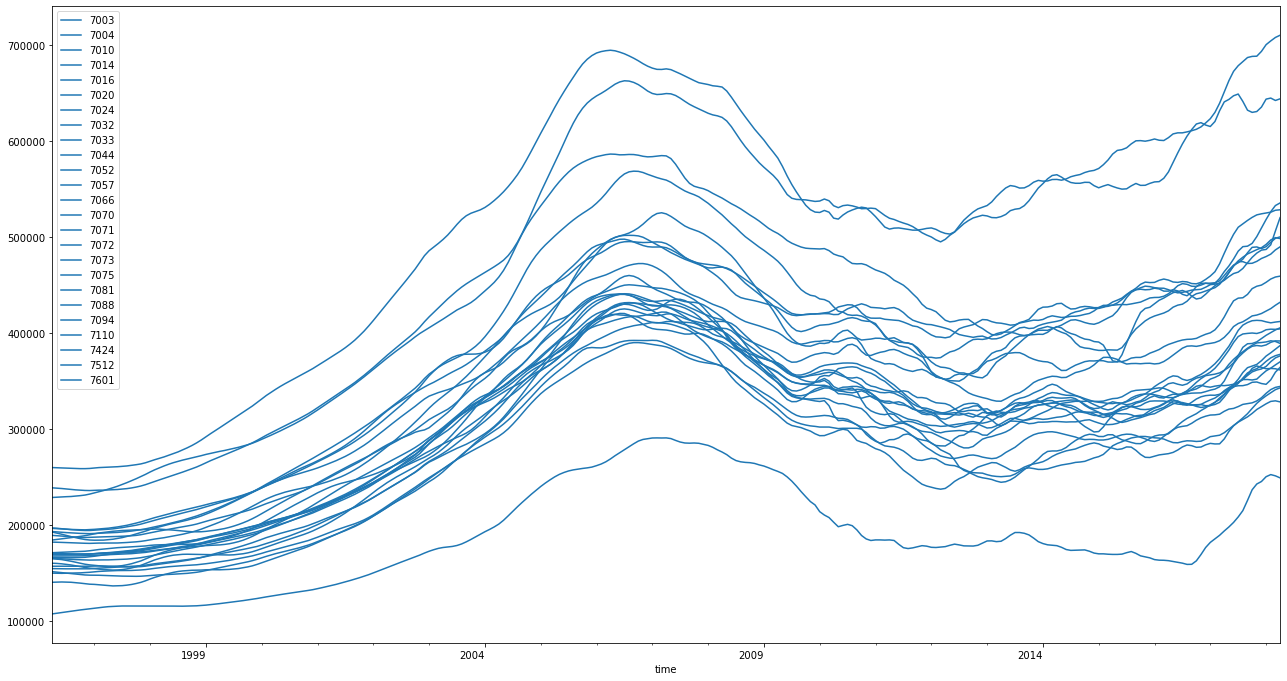

In [27]:
volatility.groupby('zip')['median_price'].plot(figsize=(22,13),subplots=True, legend=True)
plt.show()

In [28]:
top_25 = volatility.copy()
top_25 = top_25.reset_index().sort_values(by=['zip','time'])
top_25 = top_25.set_index('time')
# def monthly_roi_row(row):
#     curr_index = row.name
#     row['median_price'] 

top_25.head()

,zip,median_price
time,,
1996-04-01,7003,140800.0
1996-05-01,7003,141000.0
1996-06-01,7003,141100.0
1996-07-01,7003,141000.0
1996-08-01,7003,140800.0


In [139]:
""" For testing """
# west_orange = top_25[top_25.zip == 7052]
# west_orange['monthly_change'] = west_orange.median_price.pct_change()
# west_orange['monthly_change'].iloc[0] = 0.00

# jc = top_25[top_25.zip == 7003]
# jc['monthly_change'] = jc.median_price.pct_change()
# jc['monthly_change'].iloc[0] = 0.00

# print(265*2)
# combined = pd.concat([west_orange, jc])
# combined.iloc[265]

In [32]:
top_25_pct = pd.DataFrame()
for z in top_25.zip.unique():
    curr_df = top_25[top_25.zip == z]
    curr_df['monthly_change'] = curr_df.median_price.pct_change()
    curr_df['monthly_change'].iloc[0] = 0.00
    curr_df['roi_multiple'] = curr_df.median_price.pct_change() + 1.0
    curr_df['roi_multiple'].iloc[0] = 1.00
    
    top_25_pct = pd.concat([top_25_pct, curr_df])

print(len(top_25_pct))
print(len(top_25))

# rearrange so dataframe can be further analyzed 
# if sorted by zip then can't use time indexing 
top_25_pct = top_25_pct.reset_index().sort_values(by='time',ascending=True)
top_25_pct = top_25_pct.set_index('time')
top_25_pct.head(10)

6625
6625


,zip,median_price,monthly_change,roi_multiple
time,,,,
1996-04-01,7003,140800.0,0.0,1.0
1996-04-01,7016,197300.0,0.0,1.0
1996-04-01,7110,160600.0,0.0,1.0
1996-04-01,7024,260200.0,0.0,1.0
1996-04-01,7088,107900.0,0.0,1.0
1996-04-01,7033,155000.0,0.0,1.0
1996-04-01,7075,170700.0,0.0,1.0
1996-04-01,7512,166500.0,0.0,1.0
1996-04-01,7057,168100.0,0.0,1.0


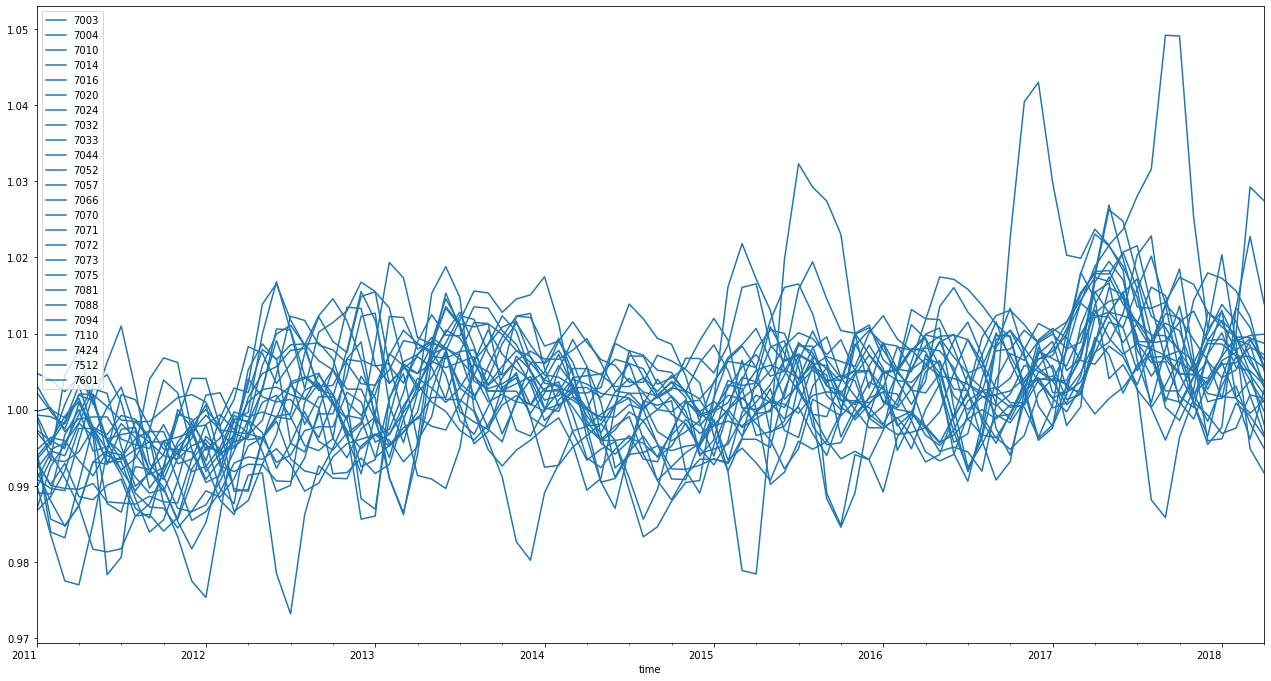

In [33]:
top_25_pct['2011':].groupby('zip')['roi_multiple'].plot(figsize=(22,13),subplots=True, legend=True)
plt.show()

<AxesSubplot:xlabel='time'>

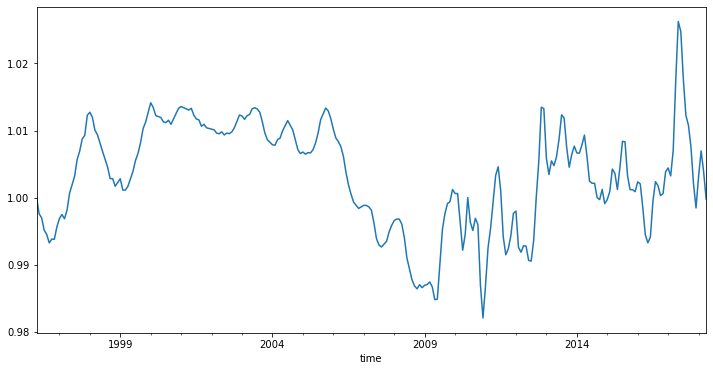

In [224]:
top_25_pct[top_25_pct.zip == 7052]['roi_multiple'].plot(figsize=(12,6))

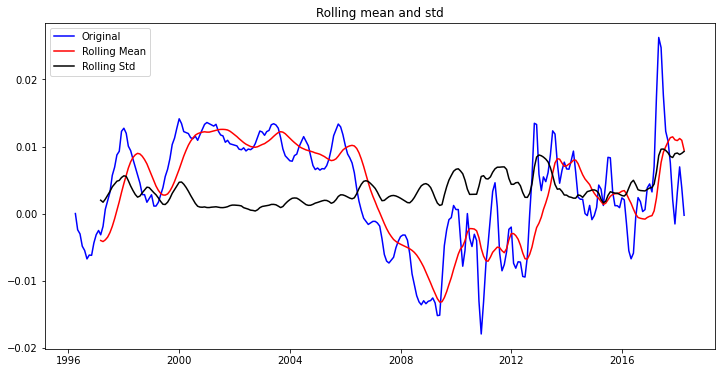

Test Statistic                  -1.450367
p-value                          0.557906
#lags used                      15.000000
number of observations used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [230]:
stationarity_check(top_25_pct[top_25_pct.zip == 7052]['monthly_change'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

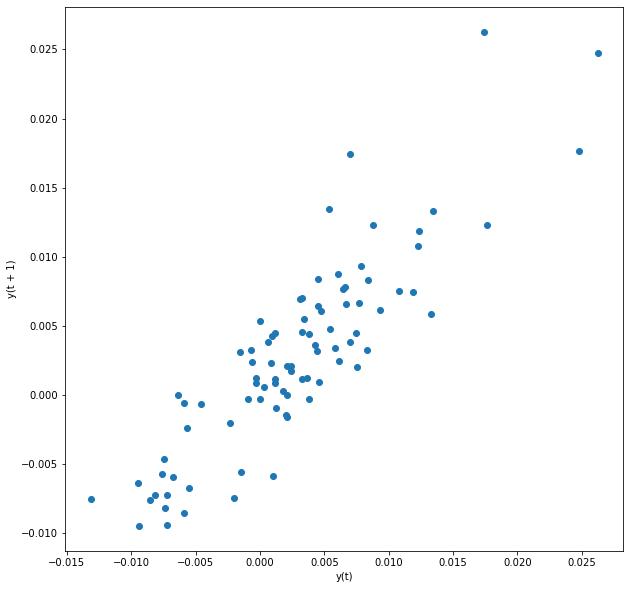

In [268]:
lag_plot(west_orange['2011':]['monthly_change'], lag=1)

In [ ]:
result_add = seasonal_decompose(nj_avg, model='additive', extrapolate_trend='freq')
result_mult = seasonal_decompose(nj_avg, model='multiplicative', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_mult.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

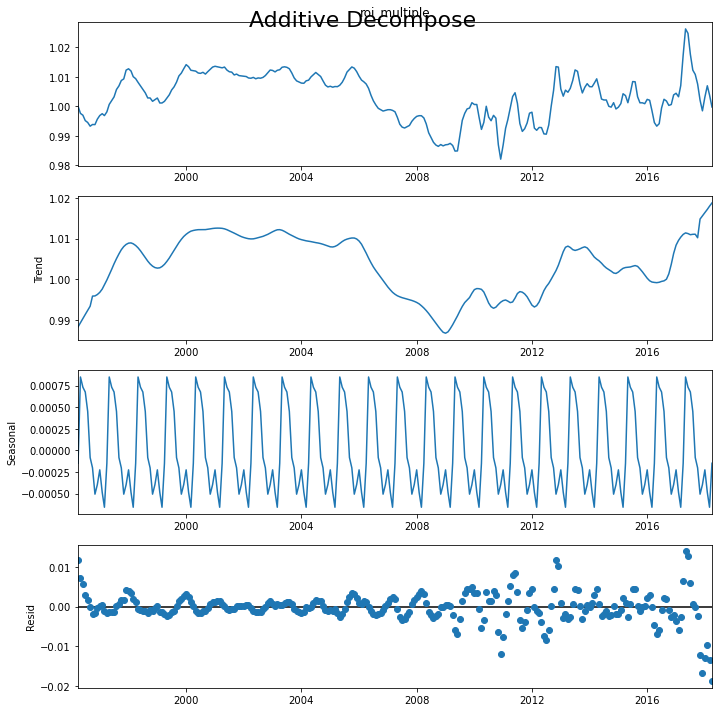

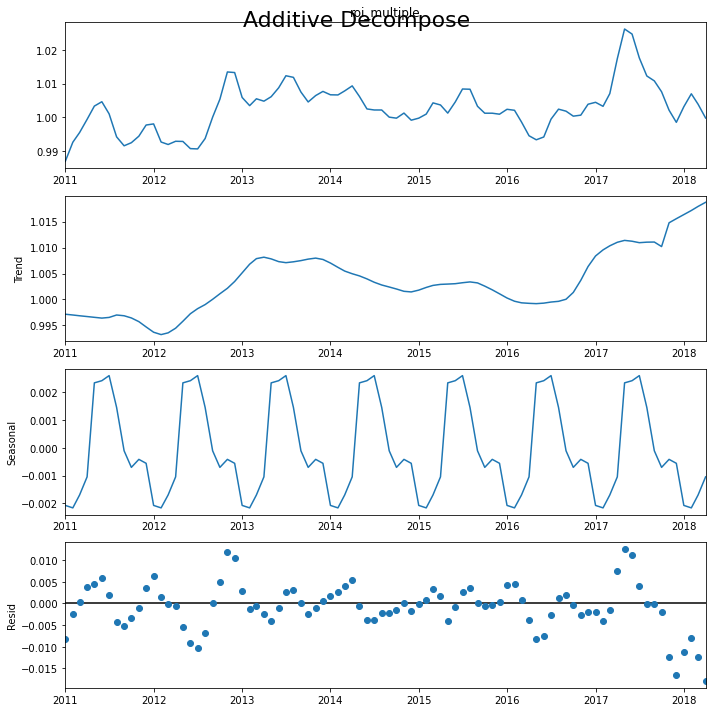

In [259]:
west_orange = top_25_pct[top_25_pct.zip == 7052]
result_add = seasonal_decompose(west_orange['2011':].roi_multiple, model='additive', extrapolate_trend='freq')
result_mult = seasonal_decompose(west_orange.roi_multiple, model='additive', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_mult.plot().suptitle('Additive Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

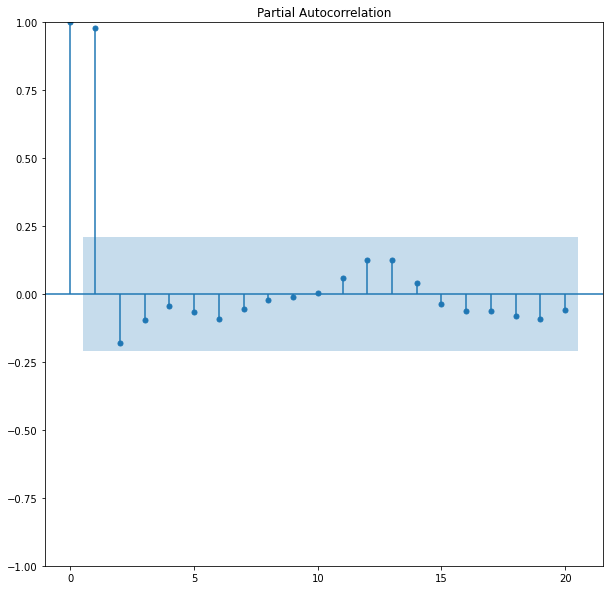

In [255]:
plot_pacf(west_orange['2011':]['median_price'])
plt.show()

# Model prototyping

In [167]:
split = int(len(west_orange)*.7)

train_data, test_data = west_orange[:split], west_orange[split:]

,zip,median_price,monthly_change
time,,,
1996-04-01,7052,165300.0,0.000000
1996-05-01,7052,164900.0,-0.002420
1996-06-01,7052,164400.0,-0.003032
1996-07-01,7052,163600.0,-0.004866
1996-08-01,7052,162700.0,-0.005501


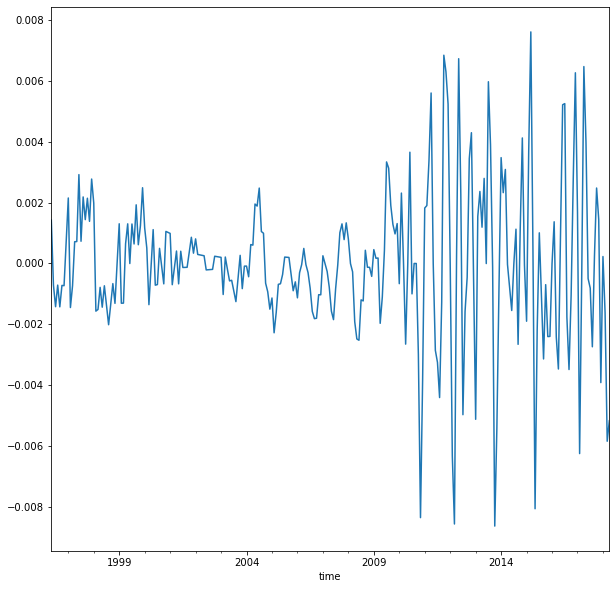

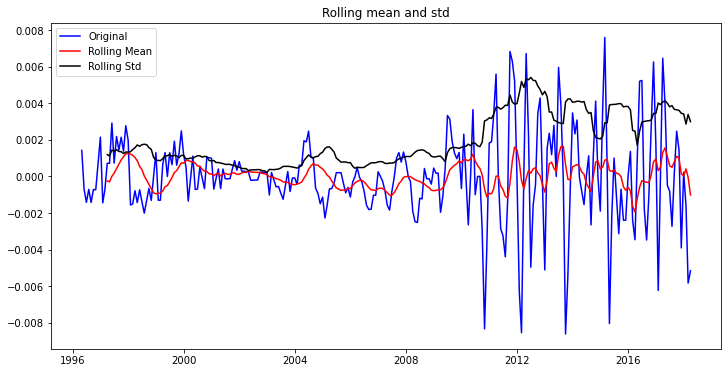

Test Statistic                -6.710500e+00
p-value                        3.691144e-09
#lags used                     1.600000e+01
number of observations used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64
(0.01, False)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2549.471, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2432.116, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2481.306, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2523.656, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2434.109, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2512.021, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2551.328, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2523.828, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-2552.269, Time=0.50 sec
 ARIMA(3,0,0)(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(2, 0, 0)   Log Likelihood                1280.135
Date:                Mon, 28 Feb 2022   AIC                          -2554.270
Time:                        14:52:26   BIC                          -2543.542
Sample:                             0   HQIC                         -2549.959
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6273      0.042     15.061      0.000       0.546       0.709
ar.L2         -0.4996      0.039    -12.826      0.000      -0.576      -0.423
sigma2      3.584e-06   2.33e-07     15.368      0.000    3.13e-06    4.04e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                31.17
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               6.20   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [165]:
# 2,0,0 because the 1st zero means differencing - here I difference BEFORE I fit the model. If I don't difference I need to use a 2,1,0 model 
# second 0 indicates no moving average 

test = top_25_pct[top_25_pct.zip == 7003]['monthly_change'].diff(periods=1).dropna()
test.plot()
plt.show()
stationarity_check(test)
print(adf_test.should_diff(test))

arima_model = auto_arima(test, seasonal=True, error_action='warn', trace=True, 
                         supress_warnings=True, stepwise=True, random_state=42, n_fits=200)
arima_model.summary()

In [166]:
arima_model = auto_arima(top_25_pct[top_25_pct.zip == 7003]['monthly_change'], seasonal=True, error_action='warn', trace=True, 
                         supress_warnings=True, stepwise=True, random_state=42, n_fits=200)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2549.471, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2432.116, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2481.306, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2523.656, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2434.107, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2512.021, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2551.328, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2523.828, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2552.269, Time=0.53 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2551.158, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2549.033, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2554.270, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2483.300, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2553.160, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(2, 1, 0)   Log Likelihood                1280.135
Date:                Mon, 28 Feb 2022   AIC                          -2554.270
Time:                        14:53:08   BIC                          -2543.542
Sample:                             0   HQIC                         -2549.959
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6273      0.042     15.062      0.000       0.546       0.709
ar.L2         -0.4996      0.039    -12.827      0.000      -0.576      -0.423
sigma2      3.584e-06   2.33e-07     15.368      0.000    3.13e-06    4.04e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                31.17
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               6.20   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
import itertools

test = [1,2,3,4,5]

combos = itertools.combinations(test, 2)
for combo in combos:
    print(combo)

(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 3)
(2, 4)
(2, 5)
(3, 4)
(3, 5)
(4, 5)


In [ ]:
# TODO combinations of pdq 

In [ ]:
# Train test split 

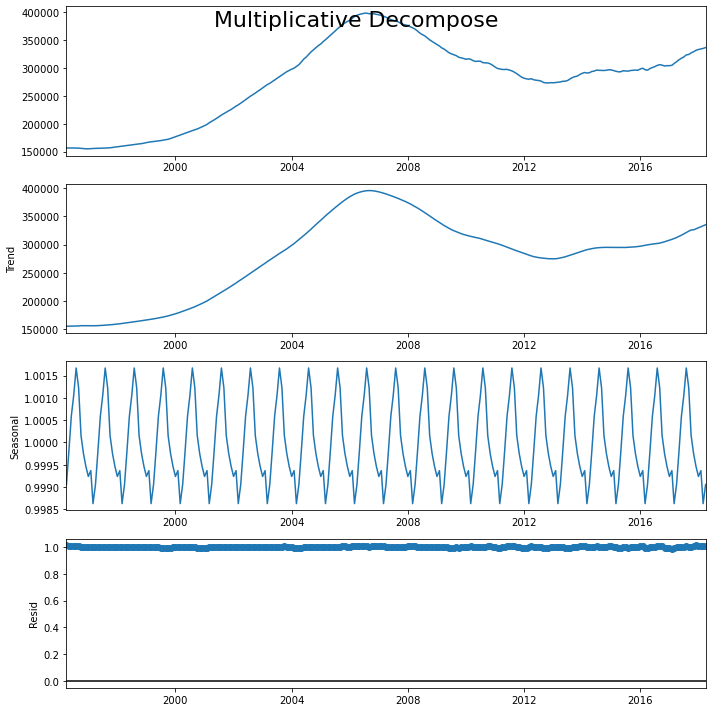

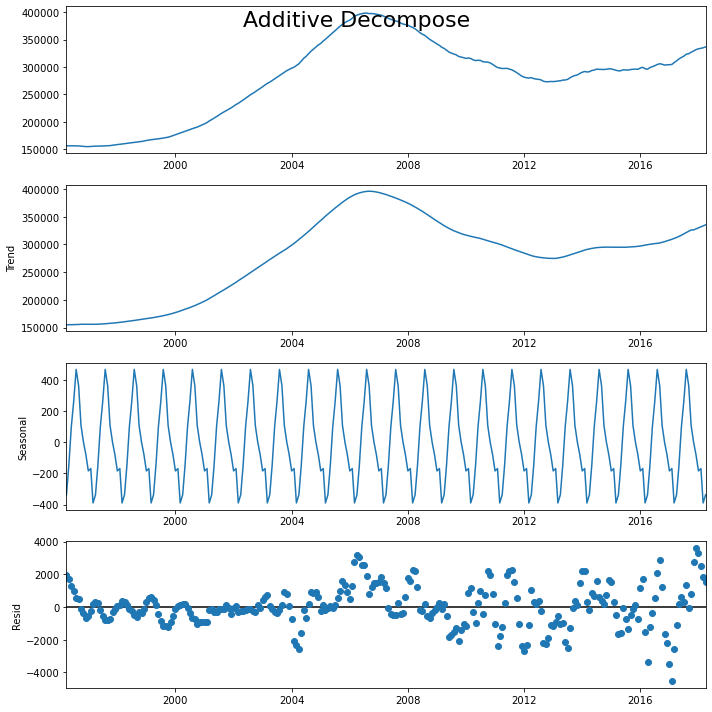

In [69]:

result_add = seasonal_decompose(nj_avg, model='additive', extrapolate_trend='freq')
result_mult = seasonal_decompose(nj_avg, model='multiplicative', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_mult.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

<AxesSubplot:xlabel='time'>

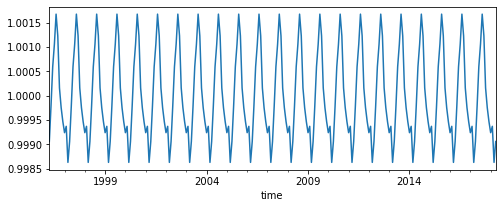

In [71]:
result_mult.seasonal.plot(figsize=(8,3))

<AxesSubplot:xlabel='time'>

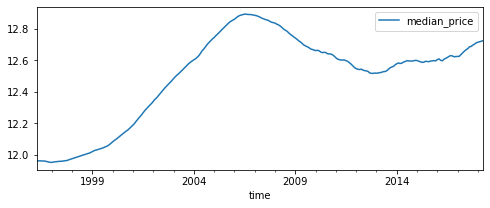

In [72]:
nj_avg_log = np.log(nj_avg)
nj_avg_log.plot(figsize=(8,3))

<AxesSubplot:xlabel='time'>

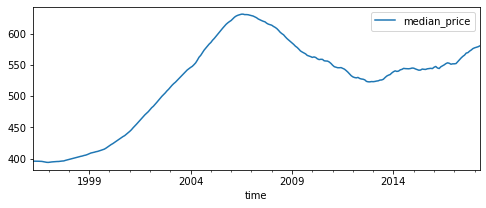

In [73]:
nj_avg_sqrt = np.sqrt(nj_avg)
nj_avg_sqrt.plot(figsize=(8,3))

<AxesSubplot:xlabel='time'>

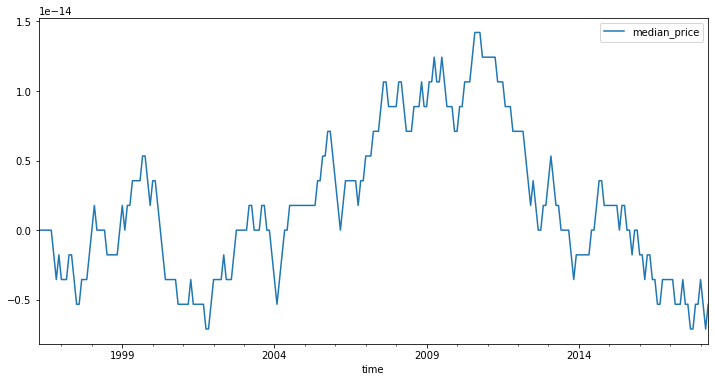

In [75]:
roll_mean = np.log(nj_avg).rolling(window=1).mean()
data_minus_roll_mean = np.log(nj_avg) - roll_mean
data_minus_roll_mean.plot(figsize=(12,6))

<AxesSubplot:xlabel='time'>

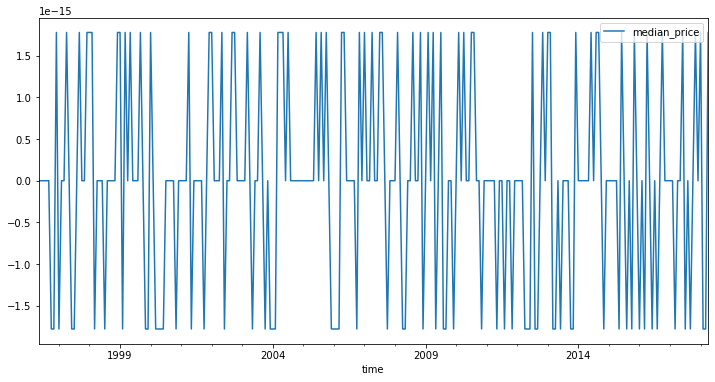

In [76]:
data_diff = data_minus_roll_mean.diff()
data_diff.dropna(inplace=True)
data_diff.plot(figsize=(12,6))

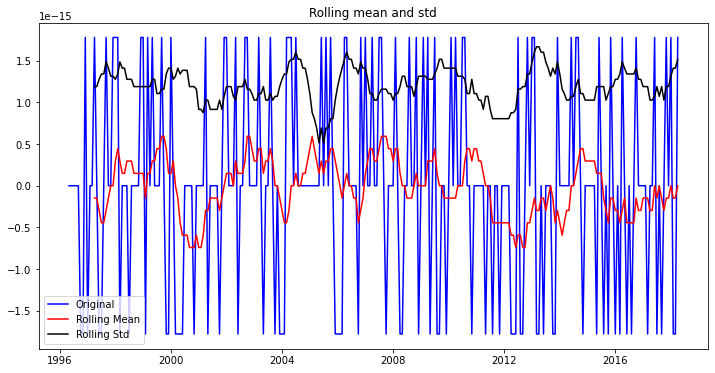

Test Statistic                -1.519492e+01
p-value                        5.939142e-28
#lags used                     0.000000e+00
number of observations used    2.630000e+02
Critical Value (1%)           -3.455461e+00
Critical Value (5%)           -2.872593e+00
Critical Value (10%)          -2.572660e+00
dtype: float64


In [77]:
stationarity_check(data_diff)

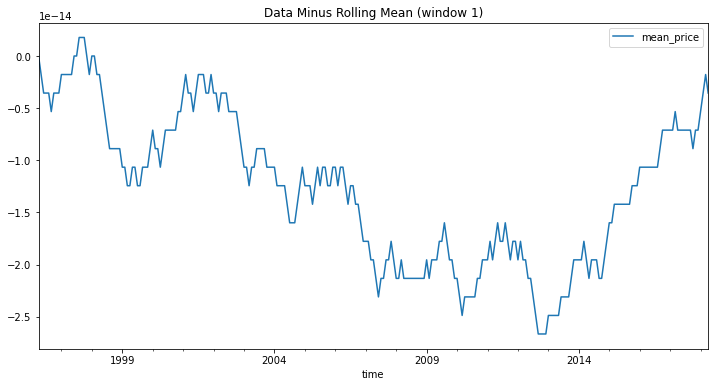

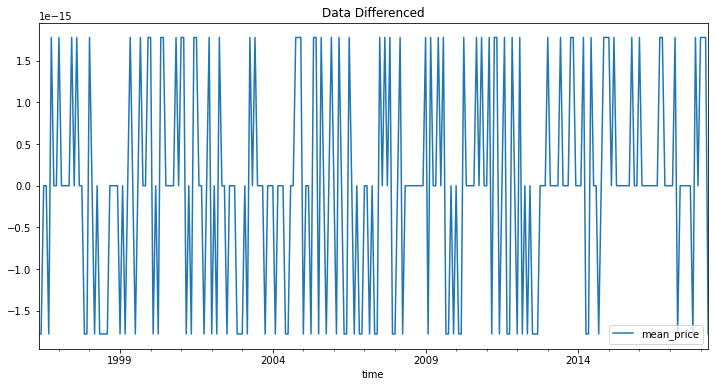

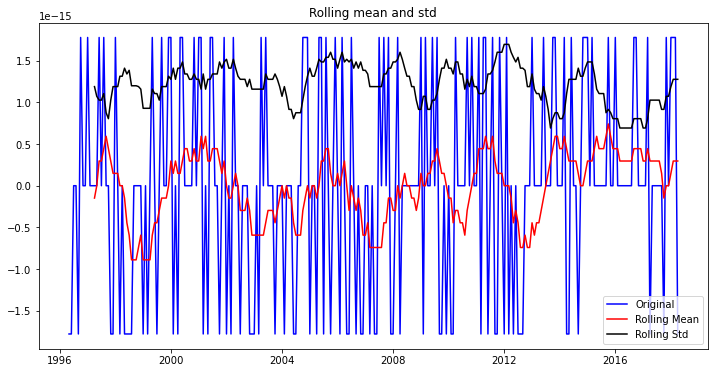

Test Statistic                -1.315197e+01
p-value                        1.361136e-24
#lags used                     1.500000e+01
number of observations used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


In [40]:
def remove_trends(df):
    roll_mean = np.log(df).rolling(window=1).mean()
    data_minus_roll_mean = np.log(df) - roll_mean
    data_minus_roll_mean.plot(figsize=(12,6))
    plt.title('Data Minus Rolling Mean (window 1)')
    plt.show()

    data_diff = data_minus_roll_mean.diff()
    data_diff.dropna(inplace=True)
    data_diff.plot(figsize=(12,6))
    plt.title('Data Differenced')
    plt.show()
    
    stationarity_check(data_diff)
    return data_diff
data_diff = remove_trends(nj_avg)

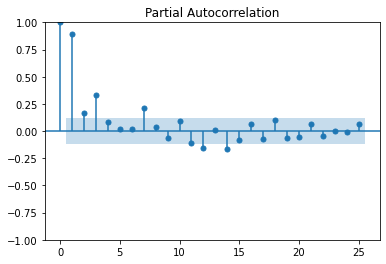

In [136]:
plot_pacf(nj_avg.diff(periods=1).bfill())
plt.show()

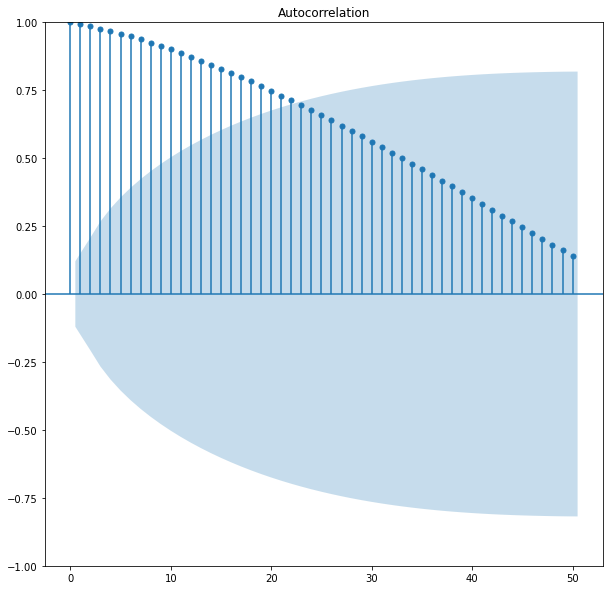

C:\Users\ntimpano\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


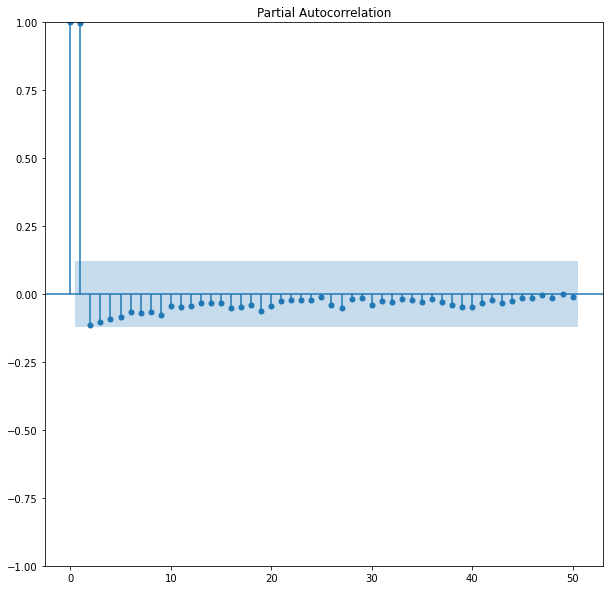

In [79]:
plot_acf(nj_avg, lags=50)
plt.show()

plot_pacf(nj_avg, lags=50)
plt.show()

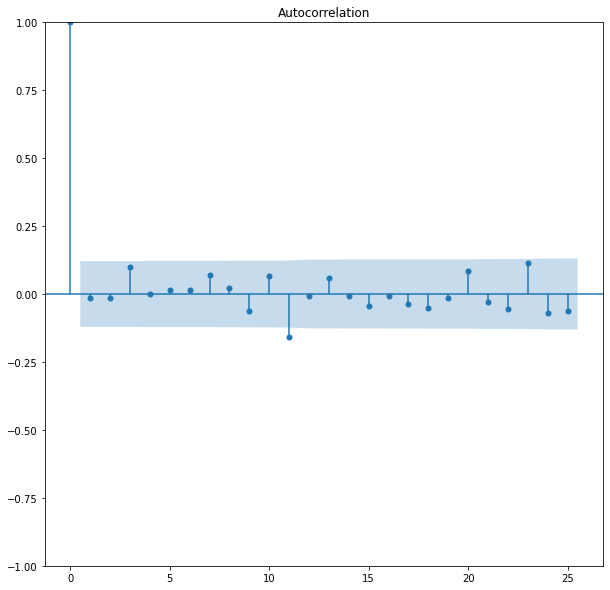

C:\Users\ntimpano\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


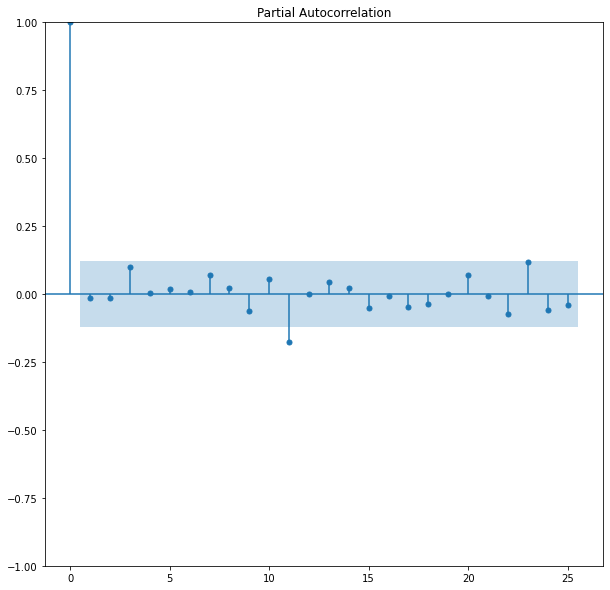

In [43]:
plot_acf(data_diff)
plt.show()

plot_pacf(data_diff)
plt.show()

In [106]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(nj_avg)

(0.38525676749450277, True)

In [81]:
adf_test.should_diff(data_diff)

(0.01, False)

In [85]:
arima_model = auto_arima(nj_avg, seasonal=True, error_action='warn', trace=True, 
                         supress_warnings=True, stepwise=True, random_state=42, n_fits=200)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4358.887, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4351.837, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4353.381, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4353.721, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4354.221, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4353.819, Time=0.03 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.609 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2174.918
Date:                Mon, 28 Feb 2022   AIC                           4351.837
Time:                        06:57:09   BIC                           4355.409
Sample:                             0   HQIC                          4353.273
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.854e+05   5.09e+04     17.383      0.000    7.86e+05    9.85e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.05   Jarque-Bera (JB):                69.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              21.90   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ntimpano\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ntimpano\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ntimpano\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ntimpano\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ntimpano\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: Valu

<AxesSubplot:>

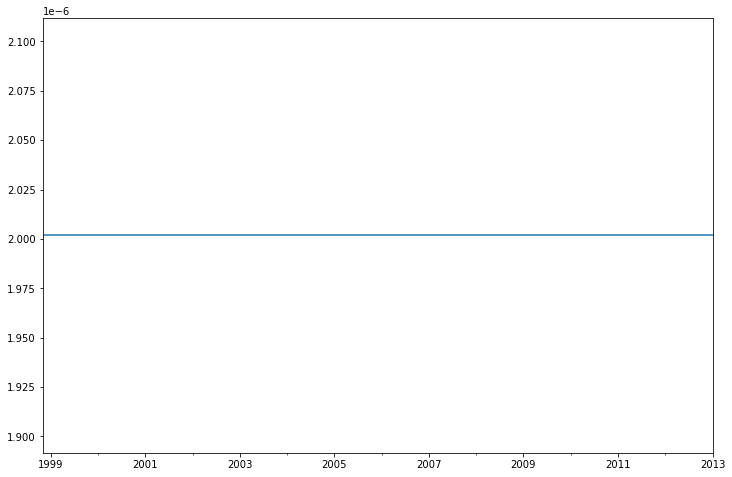

In [98]:
from statsmodels.tsa.arima.model import ARIMA
arima_model_1 = ARIMA(nj_mean, order=(0,2,0))
history=arima_model_1.fit()

arima_model_2 = ARIMA(data_diff, order=(0,0,0))
history_2 = arima_model_2.fit()

In [86]:
arima_model = auto_arima(data_diff, seasonal=True, error_action='warn', trace=True, 
                         supress_warnings=True, stepwise=True, random_state=42, n_fits=50)
print(arima_model.summary())
arima_model.plot_diagnostics()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-6163.394, Time=1.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6163.710, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6162.538, Time=0.48 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6153.058, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6800.685, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6144.958, Time=0.71 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 3.260 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:                        SARIMAX   Log Likelihood                3401.342
Date:                Mon, 28 Feb 2022   AIC                          -6800.685
Time:                        06:57:29   BIC                          -6797.109
Sample:                             0   HQIC                         -6799.248
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.026e-12   1.17e-10      0.009      0.993   -2.28e-10     2.3e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 8.02
Prob(Q):                              0.36   Prob(JB):                         0.02
Heteroskedasticity (H):               1.08   Skew:                             0.01
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
# Notice the points fall along a line in the middle of the graph, 
# but curve off in the extremities. Normal Q-Q plots that exhibit this 
# behavior usually mean your data have more extreme values than would be expected if they truly came from a Normal distribution.
# https://data.library.virginia.edu/understanding-q-q-plots/


In [90]:
# TODO make predictions using differenced data vs non differenced data 